In [ ]:
#importing the libraries
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df_apple=pd.read_csv('/content/drive/MyDrive/ds/APPLE.csv')


In [ ]:
df_apple.head()

,Date,Adj Close,AAPL_Close(t),High,Low,Open,Volume,AAPL_Close(t-1),AAPL_Close(t-2),AAPL_Close(t-5),...,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month
0,2009-10-16 00:00:00+00:00,5.671556,6.716071,6.798571,6.708571,6.762500,431426800,6.805714,6.831786,6.802500,...,42,0,0,0,0,0,0,0,2009,10
1,2009-10-19 00:00:00+00:00,5.726144,6.780714,6.785714,6.626786,6.708929,942230800,6.716071,6.805714,6.814643,...,43,0,0,0,0,0,0,0,2009,10
2,2009-10-20 00:00:00+00:00,5.994566,7.098571,7.205357,7.066071,7.164286,1141039200,6.780714,6.716071,6.786429,...,43,0,0,0,0,0,0,0,2009,10
3,2009-10-21 00:00:00+00:00,6.180351,7.318571,7.453929,7.115357,7.125714,1193726800,7.098571,6.780714,6.831786,...,43,0,0,0,0,0,0,0,2009,10
4,2009-10-22 00:00:00+00:00,6.188795,7.328571,7.423214,7.232500,7.310714,791392000,7.318571,7.098571,6.805714,...,43,0,0,0,0,0,0,0,2009,10


In [ ]:
df_apple['Date']=pd.to_datetime(df_apple['Date']).dt.date

In [ ]:
df_apple.set_index('Date',inplace=True)

In [ ]:
scaler=MinMaxScaler()
scaled_apple=scaler.fit_transform(df_apple[['Adj Close']])
df_apple_scaled=pd.DataFrame(scaled_apple,columns=['Adj Close'],index=df_apple.index)

In [ ]:
df_apple_scaled.head()

,Adj Close
Date,
2009-10-16,0.000000
2009-10-19,0.000239
2009-10-20,0.001411
2009-10-21,0.002223
2009-10-22,0.002260


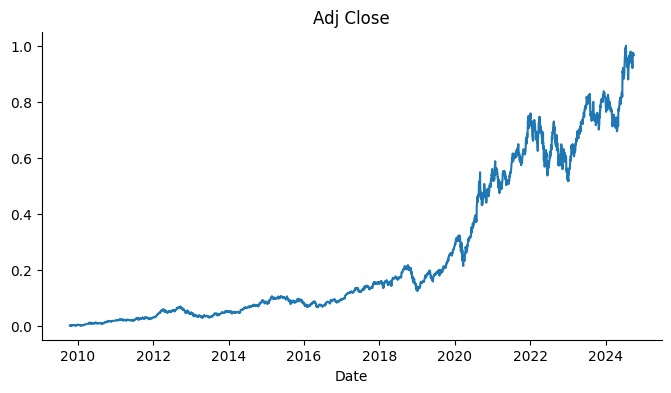

In [ ]:
# @title Adj Close

from matplotlib import pyplot as plt
df_apple_scaled['Adj Close'].plot(kind='line', figsize=(8, 4), title='Adj Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_apple_scaled['Adj Close'], window_size)


In [ ]:
split_index=3000
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 60, 1), (3000,), (702, 60, 1), (702,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [ ]:
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - RootMeanSquaredError: 0.0240 - loss: 6.7259e-04 - val_RootMeanSquaredError: 0.0582 - val_loss: 0.0034
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - RootMeanSquaredError: 0.0127 - loss: 1.6262e-04 - val_RootMeanSquaredError: 0.0552 - val_loss: 0.0030
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - RootMeanSquaredError: 0.0111 - loss: 1.2379e-04 - val_RootMeanSquaredError: 0.0405 - val_loss: 0.0016
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - RootMeanSquaredError: 0.0106 - loss: 1.1349e-04 - val_RootMeanSquaredError: 0.0526 - val_loss: 0.0028
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - RootMeanSquaredError: 0.0101 - loss: 1.0202e-04 - val_RootMeanSquaredError: 0.0691 - val_loss: 0.0048
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - RootMeanSquaredError: 0.0097 - loss: 9.5550e-05 - val_RootMeanSquaredError: 0.0344 - val_loss: 0.0012
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 12m

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_Apple.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 11.0285, RMSE: 13.8306, MSE: 191.2844


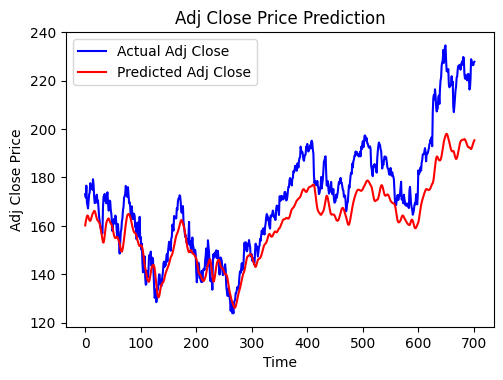

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_apple_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_apple_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/ds/lstm_Apple.keras')

In [ ]:
# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Stock Prices for the next 4 days:  [225.18727, 225.12515, 225.07657, 225.0361]


**Arima model**

<Axes: xlabel='Date'>

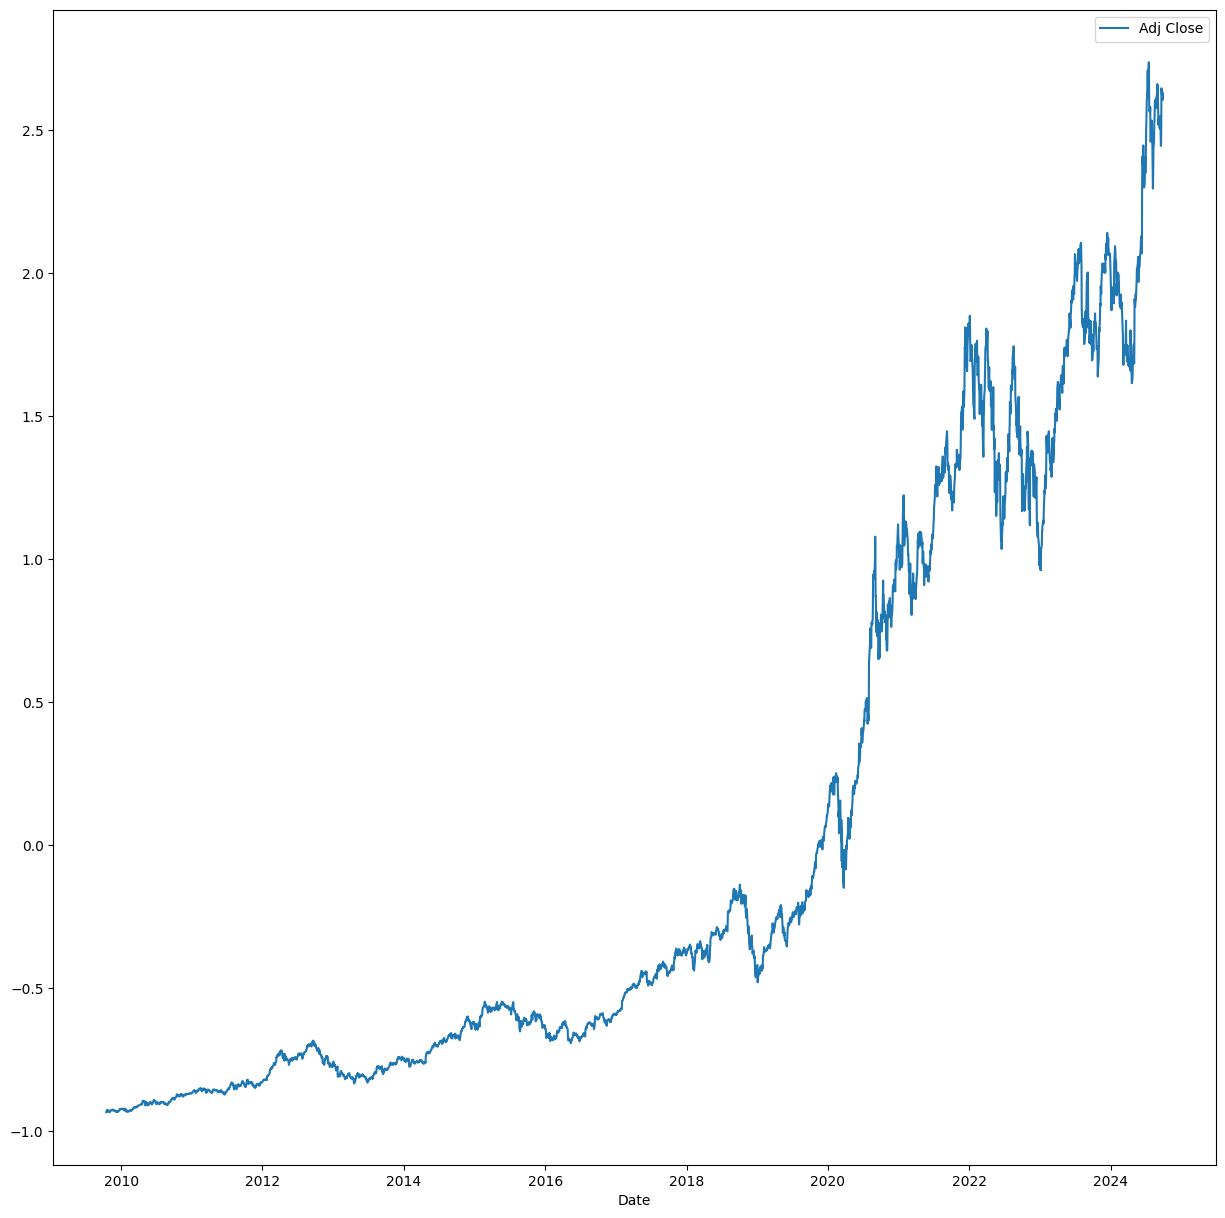

In [ ]:
df_apple_scaled.plot()

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_apple_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  1.2625094279681854
p-value 0.9963905477708349
critical values -16976.67368410458
Reject the null hypotheise , it mean data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_apple_scaled['first difference']=df_apple_scaled['Adj Close']-df_apple_scaled['Adj Close'].shift(1)

In the first-order differencing method, we subtract each data point from the previous one to remove trends and stabilize the series. This transformation is often enough to make the data stationary.

If the series does not become stationary after the first differencing, we apply second-order differencing, where the differencing process is repeated on the first-differenced data. This process can be continued (e.g., third-order differencing) until the data becomes stationary. However, it is important to stop once stationarity is achieved to avoid over-differencing, which can introduce unnecessary complexity.

<Axes: xlabel='Date'>

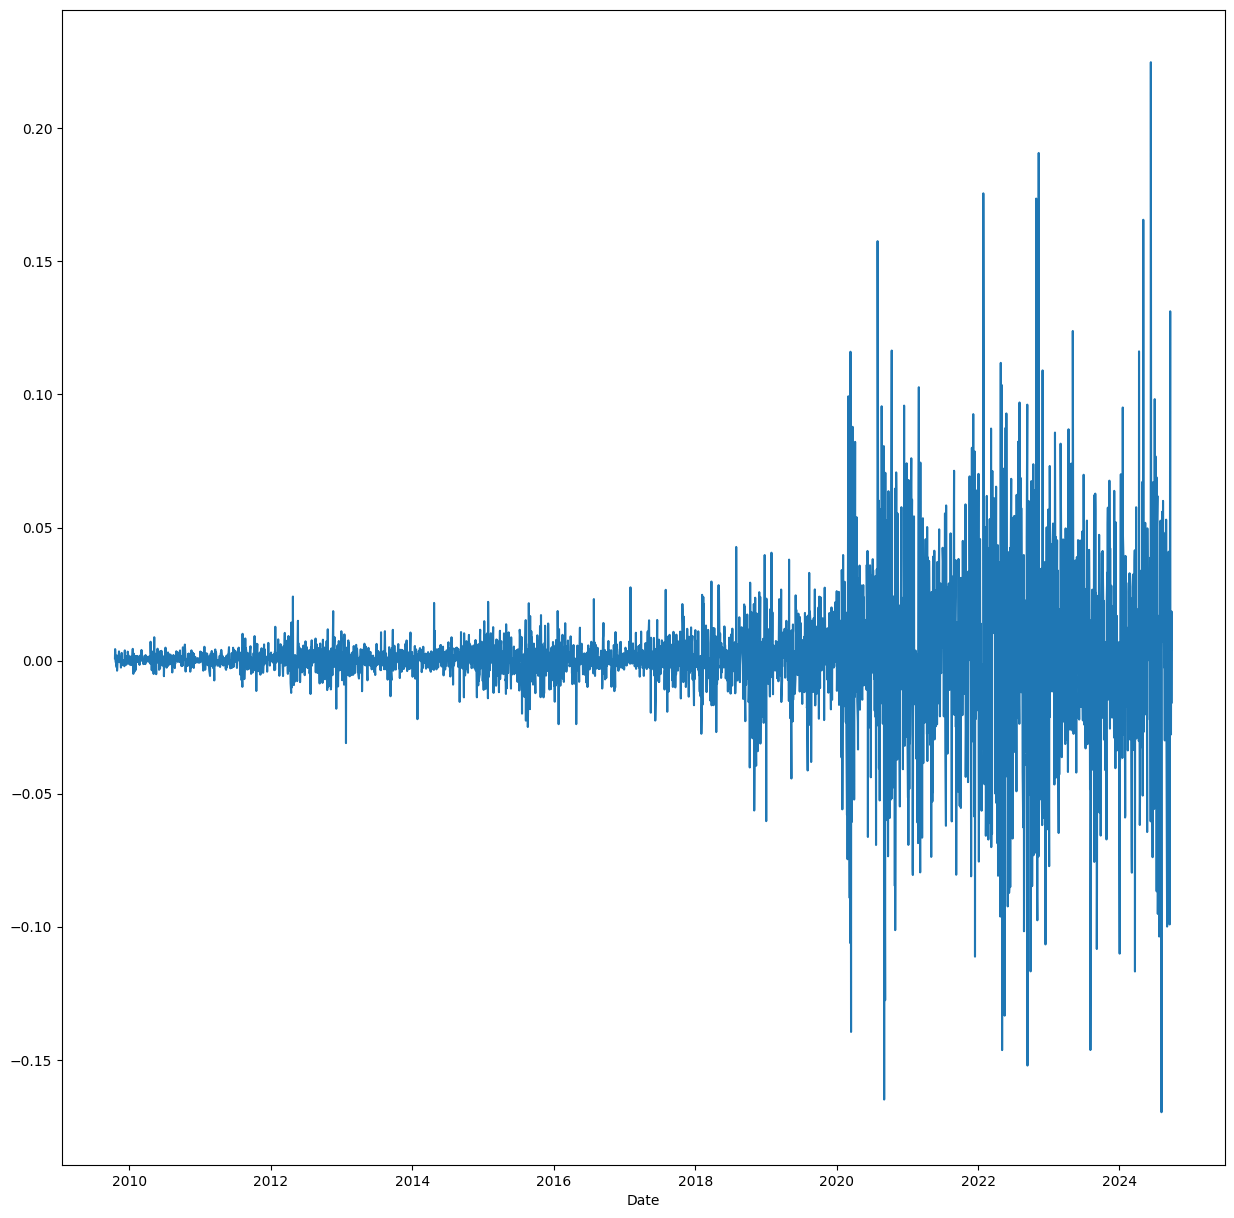

In [ ]:
# Now checking data is stationary or not using graphs.
df_apple_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_apple_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -13.484517882071001
p-value 3.1932932615238845e-25
critical values -16971.538586619652
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required

### After performing all preprocessing and testing. time to impliment ARIMA##

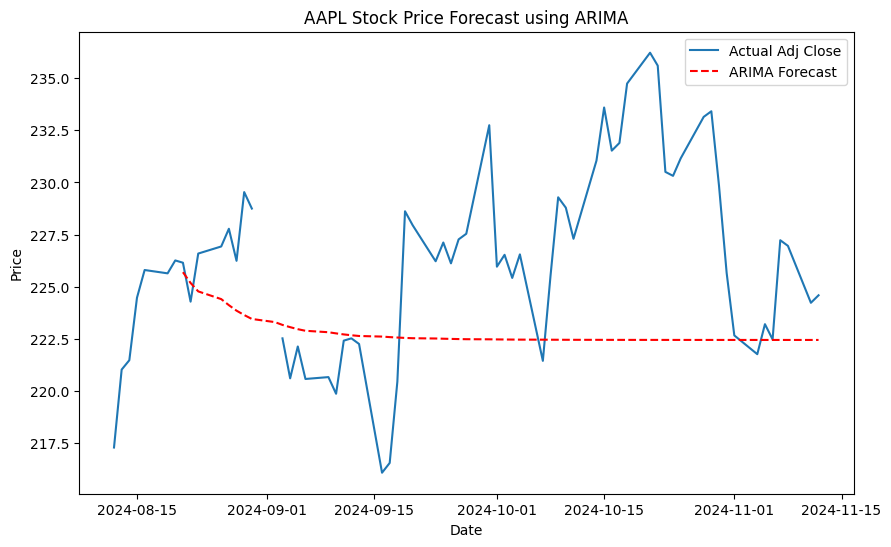

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the date index has a frequency (for example, daily or business days)
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency, adjust if needed

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend the forecast into the future by 10 days
forecast_steps = 10
df_apple_scaled = data.copy()
df_apple_scaled['forecast_ARIMA'] = model_fit1.predict(start=len(data) - 60, end=len(data) + forecast_steps - 1, dynamic=True)

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_apple_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_apple_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("AAPL Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


The ARIMA model appears to perform poorly in forecasting. Let’s evaluate its performance using some metrics.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Forecast for the last 60 days plus an extra 10 days
forecast_steps = 10
df_apple_scaled = data.copy()
df_apple_scaled['forecast_ARIMA'] = model_fit1.predict(start=len(data) - 60, end=len(data) + forecast_steps - 1, dynamic=True)

# Check if 'forecast_ARIMA' column was created successfully
if 'forecast_ARIMA' in df_apple_scaled.columns:
    # Only calculate MSE, MAE, and RMSE where forecast_ARIMA has values
    forecast_period = df_apple_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE for this period
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print MSE, MAE, and RMSE values
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")



Mean Squared Error (MSE): 35.287125664779595
Mean Absolute Error (MAE): 4.731938647626582
Root Mean Squared Error (RMSE): 5.9402967657163055


In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/APPLE.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          32.603859        0.430172       32.587109       1.735046
1          31.001202        0.406188       30.987327       1.657812
2          29.477445        0.387195       29.465257       1.577412
3          28.029248        0.368066       28.027519       1.509182
4          26.652127        0.349891       26.649272       1.443760
..               ...             ...             ...            ...
513         0.052159        0.000826        0.358955       0.045412
514         0.052060        0.000839        0.358939       0.045430
515         0.051960        0.000847        0.358951       0.045428
516         0.051843        0.000831        0.358942       0.045425
517         0.051733        0.000825        0.358934       0.045389

[518 rows x 4 columns]
Best number of boosting rounds: 517


Mean Squared Error (MSE): 968.9427447313163
Root Mean Squared Error (RMSE): 31.127845166848868
Mean Absolute Error (MAE): 23.55451203407125


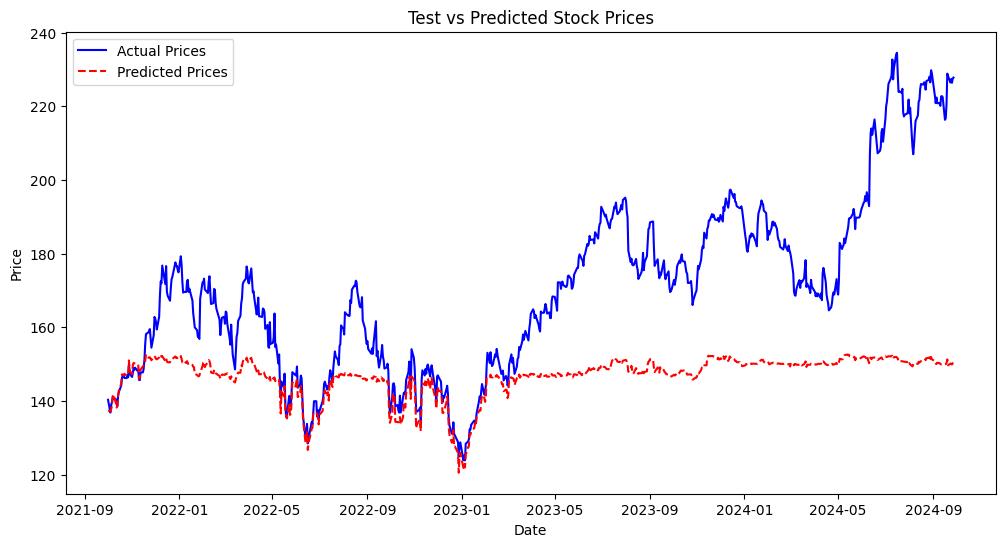

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  140.300613  137.388321
2021-10-04 00:00:00+00:00  136.848404  137.162369
2021-10-05 00:00:00+00:00  138.785950  137.774017
2021-10-06 00:00:00+00:00  139.661316  138.590759
2021-10-07 00:00:00+00:00  140.930069  141.259293


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


## **Google Dataset**

In [ ]:
df_google=pd.read_csv('/content/drive/MyDrive/ds/GOOGLE.csv')

In [ ]:
df_google.head()

,Date,Adj Close,GOOGL_Close(t),High,Low,Open,Volume,GOOGL_Close(t-1),GOOGL_Close(t-2),GOOGL_Close(t-5),...,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month
0,2009-10-16 00:00:00+00:00,13.726023,13.760010,13.882633,13.626877,13.696947,353322324,13.261011,13.396396,12.919169,...,42,0,0,0,0,0,0,0,2009,10
1,2009-10-19 00:00:00+00:00,13.781940,13.816066,13.853854,13.731982,13.831081,128587284,13.760010,13.261011,13.114114,...,43,0,0,0,0,0,0,0,2009,10
2,2009-10-20 00:00:00+00:00,13.772703,13.806807,13.837588,13.531031,13.804805,161586252,13.816066,13.760010,13.165916,...,43,0,0,0,0,0,0,0,2009,10
3,2009-10-21 00:00:00+00:00,13.757226,13.791291,13.997748,13.738739,13.761512,146677176,13.806807,13.816066,13.396396,...,43,0,0,0,0,0,0,0,2009,10
4,2009-10-22 00:00:00+00:00,13.831865,13.866116,13.888889,13.713714,13.763764,93366540,13.791291,13.806807,13.261011,...,43,0,0,0,0,0,0,0,2009,10


In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_google['Date'] = pd.to_datetime(df_google['Date']).dt.date

In [ ]:
df_google.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
google_scaled = scaler.fit_transform(df_google[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_google_scaled = pd.DataFrame(google_scaled, columns=['Adj Close'], index=df_google.index)


In [ ]:
df_google_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.015776
2009-10-19,0.016087
2009-10-20,0.016035
2009-10-21,0.015949
2009-10-22,0.016364


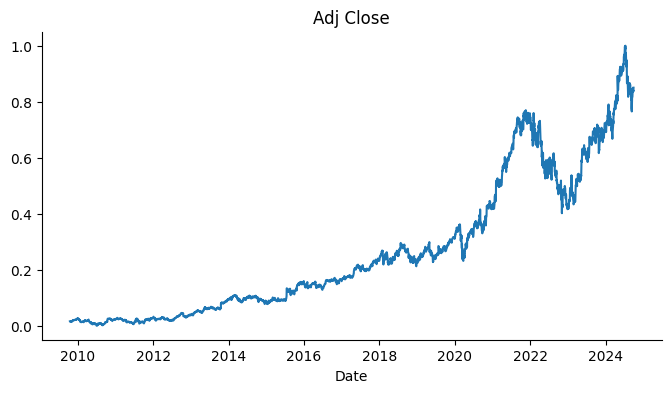

In [ ]:
# @title Adj Close

from matplotlib import pyplot as plt
df_google_scaled['Adj Close'].plot(kind='line', figsize=(8, 4), title='Adj Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_google_scaled['Adj Close'], window_size)


In [ ]:
len(df_google_scaled)*.80

3009.6000000000004

In [ ]:
split_index=3009
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3009, 60, 1), (3009,), (693, 60, 1), (693,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 61s 64ms/step - RootMeanSquaredError: 0.0313 - loss: 0.0011 - val_RootMeanSquaredError: 0.0306 - val_loss: 9.3632e-04
Epoch 2/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - RootMeanSquaredError: 0.0184 - loss: 3.4009e-04 - val_RootMeanSquaredError: 0.0444 - val_loss: 0.0020
Epoch 3/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 77s 62ms/step - RootMeanSquaredError: 0.0154 - loss: 2.3893e-04 - val_RootMeanSquaredError: 0.0387 - val_loss: 0.0015
Epoch 4/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - RootMeanSquaredError: 0.0170 - loss: 2.9135e-04 - val_RootMeanSquaredError: 0.0244 - val_loss: 5.9571e-04
Epoch 5/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - RootMeanSquaredError: 0.0154 - loss: 2.3890e-04 - val_RootMeanSquaredError: 0.0524 - val_loss: 0.0027
Epoch 6/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - RootMeanSquaredError: 0.0147 - loss: 2.1624e-04 - val_RootMeanSquaredError: 0.0326 - val_loss: 0.0011
Epoch 7/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_google.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 5.8203, RMSE: 7.6846, MSE: 59.0524


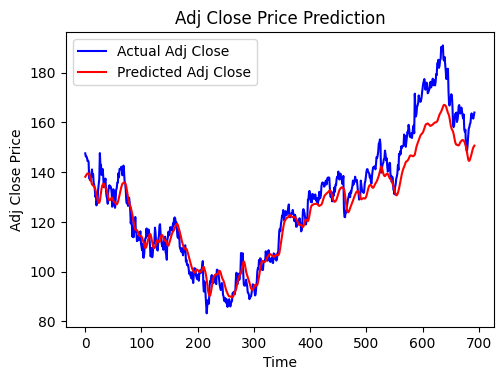

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_ibm_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_ibm_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/ds/lstm_google.keras')

**Arima Model**

<Axes: xlabel='Date'>

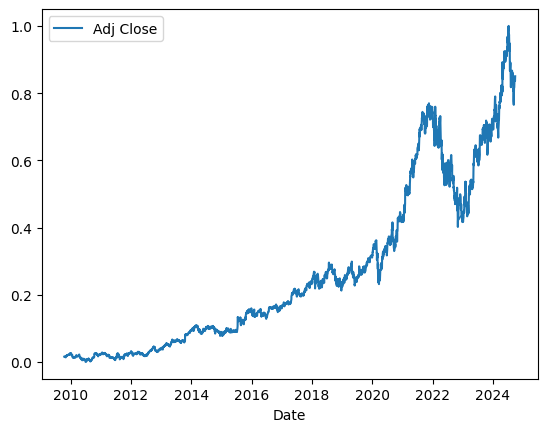

In [ ]:
df_google_scaled.plot()

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.



In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_google_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  0.9402030583850004
p-value 0.9935931850174069
critical values -25957.95172640856
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_google_scaled['first difference']=df_google_scaled['Adj Close']-df_google_scaled['Adj Close'].shift(1)


In the first-order differencing method, we subtract each data point from the previous one to remove trends and stabilize the series. This transformation is often enough to make the data stationary.

If the series does not become stationary after the first differencing, we apply second-order differencing, where the differencing process is repeated on the first-differenced data. This process can be continued (e.g., third-order differencing) until the data becomes stationary. However, it is important to stop once stationarity is achieved to avoid over-differencing, which can introduce unnecessary complexity.

<Axes: xlabel='Date'>

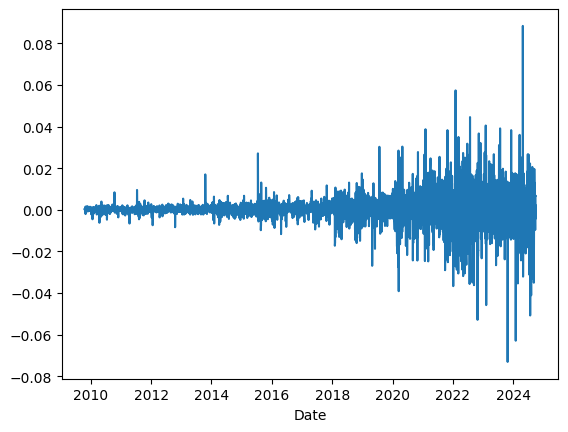

In [ ]:
# Now checking data is stationary or not using graphs.
df_google_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_google_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -11.446165368325984
p-value 6.0113919072136515e-21
critical values -25964.706060289434
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required

### Lets implement ARIMA##

Making Predictions for future values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error (MSE): 51.80422293716021
Mean Absolute Error (MAE): 5.361408322081146
Root Mean Squared Error (RMSE): 7.197515052930435


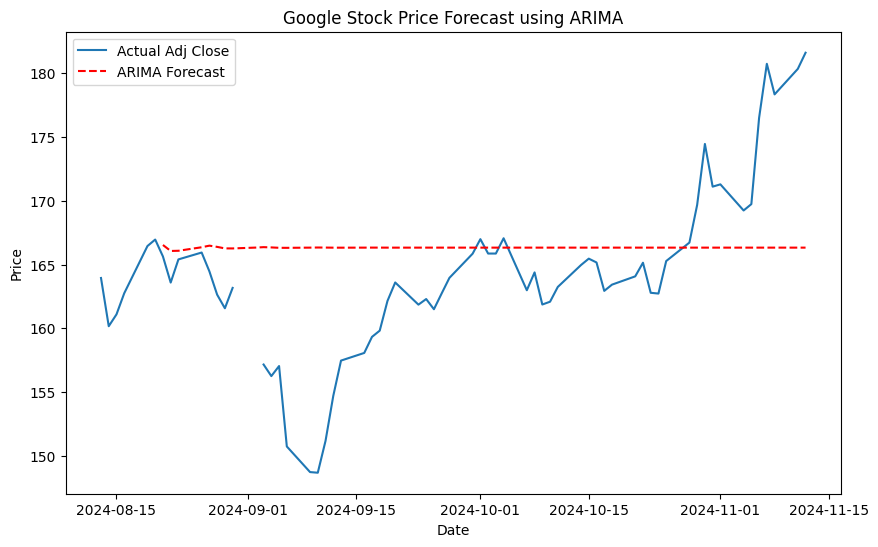

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_google_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_google_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_google_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_google_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_google_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_google_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("Google Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


The ARIMA model performs poorly because our dataset exhibits seasonality, and ARIMA is not well-suited for handling seasonal patterns effectively.

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/GOOGLE.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          26.429097        0.369565       26.410313       1.498923
1          25.135615        0.350202       25.122325       1.439646
2          23.902305        0.334628       23.895236       1.375518
3          22.729768        0.316962       22.720668       1.310596
4          21.615455        0.300159       21.608431       1.256099
..               ...             ...             ...            ...
576         0.034124        0.001036        0.305818       0.042718
577         0.034064        0.001043        0.305822       0.042698
578         0.034009        0.001043        0.305814       0.042689
579         0.033942        0.001026        0.305807       0.042693
580         0.033875        0.001010        0.305798       0.042711

[581 rows x 4 columns]
Best number of boosting rounds: 580


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

Mean Squared Error (MSE): 150.96146481466334
Root Mean Squared Error (RMSE): 12.28663765294083
Mean Absolute Error (MAE): 6.879946759406557


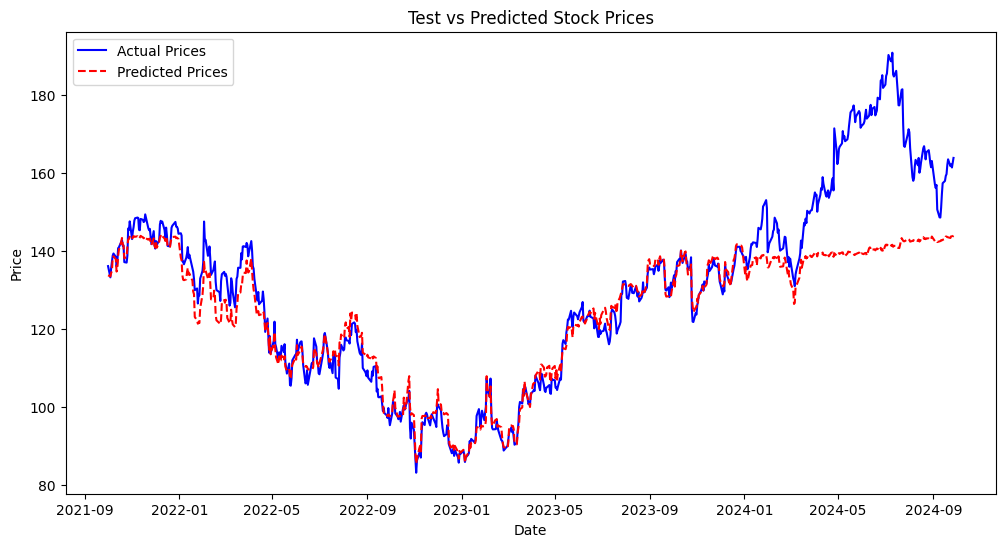

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  136.205734  133.846329
2021-10-04 00:00:00+00:00  133.329361  133.571747
2021-10-05 00:00:00+00:00  135.687012  134.437164
2021-10-06 00:00:00+00:00  137.225220  134.971832
2021-10-07 00:00:00+00:00  138.881119  138.292099


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_google.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


ARIMA struggles with seasonal data because it does not inherently account for recurring patterns, leading to inaccurate predictions even if error metrics appear similar. In contrast, LSTM excels at capturing both trends and seasonality by learning patterns over time.

While XGBoost outperforms ARIMA in terms of prediction accuracy, it is less effective than LSTM at capturing long-term trends and complex temporal dependencies. LSTM remains the best option for learning intricate patterns in time series data.

# **IBM Dataset**

In [ ]:
df_ibm=pd.read_csv('/content/drive/MyDrive/ds/IBM.csv')

In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_ibm['Date'] = pd.to_datetime(df_ibm['Date']).dt.date

In [ ]:
df_ibm.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
ibm_scaled = scaler.fit_transform(df_ibm[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_ibm_scaled = pd.DataFrame(ibm_scaled, columns=['Adj Close'], index=df_ibm.index)

In [ ]:
df_ibm_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.005576
2009-10-19,0.010752
2009-10-20,0.009877
2009-10-21,0.002770
2009-10-22,0.009403


In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_ibm_scaled['Adj Close'], window_size)


In [ ]:
split_index=3000
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 60, 1), (3000,), (702, 60, 1), (702,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - RootMeanSquaredError: 0.0558 - loss: 0.0037 - val_RootMeanSquaredError: 0.0316 - val_loss: 9.9732e-04
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - RootMeanSquaredError: 0.0286 - loss: 8.2080e-04 - val_RootMeanSquaredError: 0.0253 - val_loss: 6.3954e-04
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - RootMeanSquaredError: 0.0248 - loss: 6.1533e-04 - val_RootMeanSquaredError: 0.0222 - val_loss: 4.9459e-04
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - RootMeanSquaredError: 0.0230 - loss: 5.2774e-04 - val_RootMeanSquaredError: 0.0225 - val_loss: 5.0473e-04
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 55ms/step - RootMeanSquaredError: 0.0214 - loss: 4.5909e-04 - val_RootMeanSquaredError: 0.0190 - val_loss: 3.5933e-04
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - RootMeanSquaredError: 0.0212 - loss: 4.5782e-04 - val_RootMeanSquaredError: 0.0253 - val_loss: 6.3899e-04
Epoch 7/50
800/800 ━━━━━━━━━━━━━

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_ibm.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 7.5402, RMSE: 11.8750, MSE: 141.0156


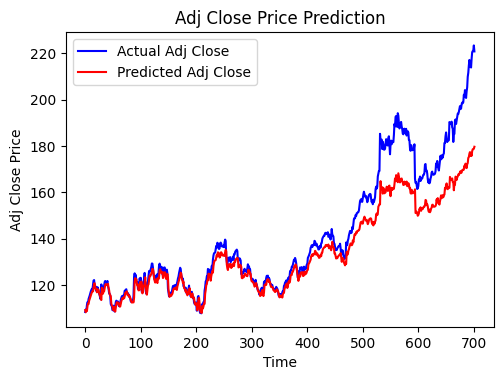

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_ibm_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_ibm_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


**ARIMA**

<Axes: xlabel='Date'>

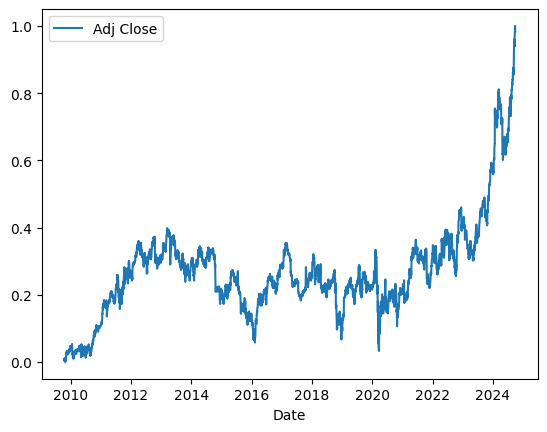

In [ ]:
df_ibm_scaled.plot()

The data clearly demonstrates a trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_ibm_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  0.24455239370884962
p-value 0.9746525739454815
critical values -23946.085495182022
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_ibm_scaled['first difference']=df_ibm_scaled['Adj Close']-df_ibm_scaled['Adj Close'].shift(1)

<Axes: xlabel='Date'>

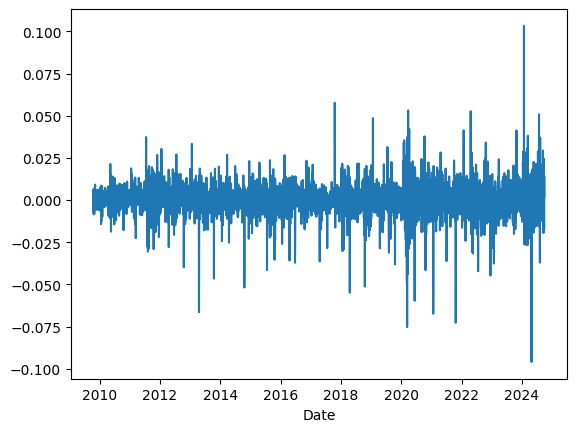

In [ ]:
# Now checking data is stationary or not using graphs.
df_ibm_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_ibm_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -18.196940015767215
p-value 2.4112972570228895e-30
critical values -23940.870562116717
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required

### Lets implement the ARIMA Model

Mean Squared Error (MSE): 453.5806804184695
Mean Absolute Error (MAE): 17.98875733574756
Root Mean Squared Error (RMSE): 21.29743365803658


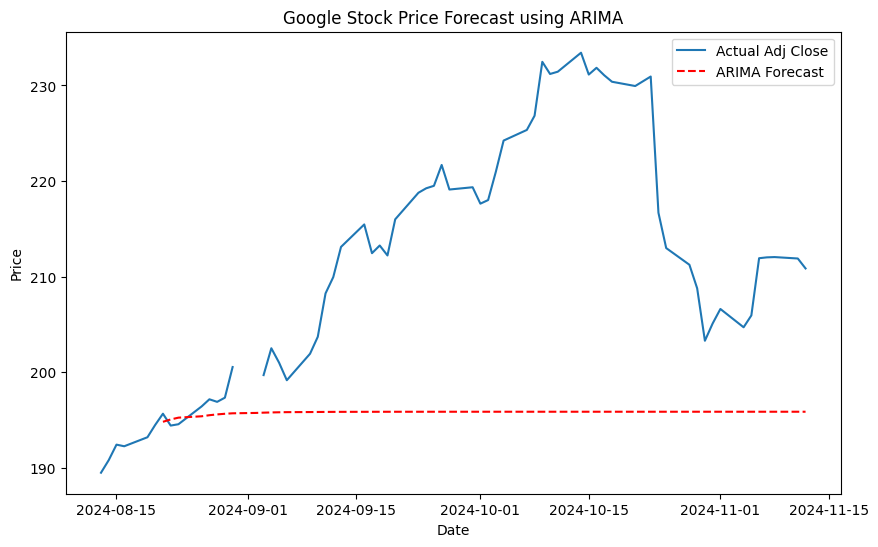

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_ibm_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_ibm_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_ibm_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_ibm_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_ibm_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_ibm_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("Google Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


**Xgboost**

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/IBM.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          12.679807        0.072654       12.686337       0.293794
1          12.061503        0.069776       12.069513       0.280375
2          11.473994        0.066788       11.481868       0.268413
3          10.915479        0.063204       10.921914       0.256780
4          10.385088        0.060190       10.392923       0.246059
..               ...             ...             ...            ...
995         0.034887        0.000808        0.488701       0.080720
996         0.034823        0.000812        0.488693       0.080724
997         0.034769        0.000805        0.488701       0.080709
998         0.034704        0.000812        0.488696       0.080710
999         0.034639        0.000818        0.488696       0.080712

[1000 rows x 4 columns]
Best number of boosting rounds: 996


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=996, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error (MSE): 946.3093366432647
Root Mean Squared Error (RMSE): 30.76214128833142
Mean Absolute Error (MAE): 18.585348880037348


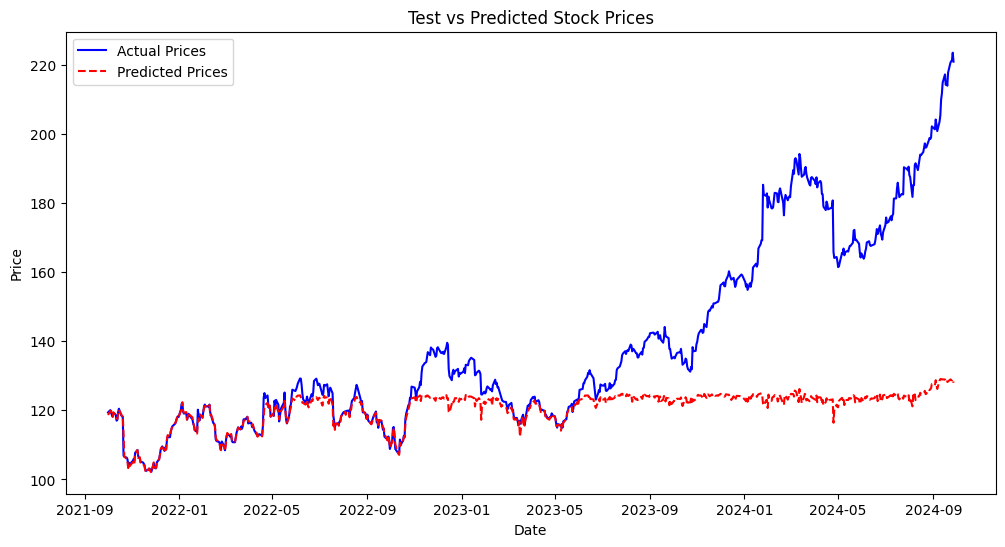

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  119.380234  118.627678
2021-10-04 00:00:00+00:00  120.038269  119.797768
2021-10-05 00:00:00+00:00  119.238625  119.801651
2021-10-06 00:00:00+00:00  118.580605  118.658745
2021-10-07 00:00:00+00:00  118.122482  118.132454


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_ibm.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


In this case, LSTM is the most effective model for capturing the trend in our seasonal dataset. ARIMA struggles with the complex seasonal patterns, leading to poor trend tracking. XGBoost handles seasonality better than ARIMA due to its adaptability to non-linear patterns but still falls short compared to LSTM. LSTM’s ability to capture long-term dependencies and seasonal patterns makes it the preferred model for this dataset.


In [ ]:
df_jnj=pd.read_csv('/content/drive/MyDrive/ds/JNJ.csv')

In [ ]:
df_jnj.head()

,Date,Adj Close,JNJ_Close(t),High,Low,Open,Volume,JNJ_Close(t-1),JNJ_Close(t-2),JNJ_Close(t-5),...,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month
0,2009-10-16 00:00:00+00:00,38.942230,60.459999,60.709999,60.250000,60.570000,13911200,60.939999,60.549999,61.740002,...,42,0,0,0,0,0,0,0,2009,10
1,2009-10-19 00:00:00+00:00,39.393116,61.160000,61.470001,60.419998,60.610001,11443300,60.459999,60.939999,62.529999,...,43,0,0,0,0,0,0,0,2009,10
2,2009-10-20 00:00:00+00:00,39.025982,60.590000,61.590000,60.509998,61.310001,15725600,61.160000,60.459999,61.009998,...,43,0,0,0,0,0,0,0,2009,10
3,2009-10-21 00:00:00+00:00,38.845661,60.310001,61.080002,60.279999,60.599998,12529900,60.590000,61.160000,60.549999,...,43,0,0,0,0,0,0,0,2009,10
4,2009-10-22 00:00:00+00:00,39.251411,60.939999,61.240002,60.040001,60.150002,9926600,60.310001,60.590000,60.939999,...,43,0,0,0,0,0,0,0,2009,10


In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_jnj['Date'] = pd.to_datetime(df_jnj['Date']).dt.date

In [ ]:
df_jnj.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
jnj_scaled = scaler.fit_transform(df_jnj[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_jnj_scaled = pd.DataFrame(jnj_scaled, columns=['Adj Close'], index=df_jnj.index)


In [ ]:
df_jnj_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.009614
2009-10-19,0.012946
2009-10-20,0.010233
2009-10-21,0.008901
2009-10-22,0.011899


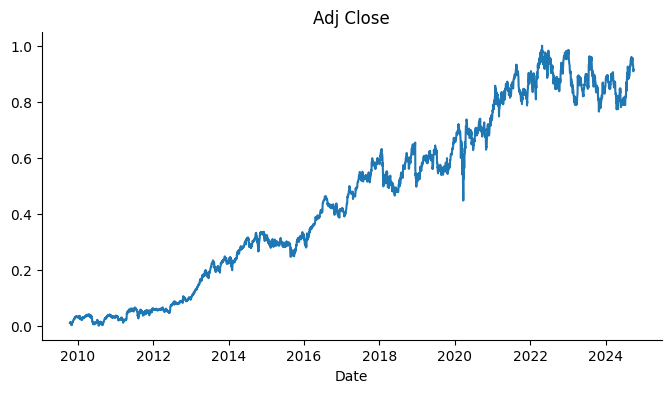

In [ ]:
# @title Adj Close
from matplotlib import pyplot as plt
df_jnj_scaled['Adj Close'].plot(kind='line', figsize=(8, 4), title='Adj Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_jnj_scaled['Adj Close'], window_size)


In [ ]:
split_index=3009 #80 % for train and remain for test
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3009, 60, 1), (3009,), (693, 60, 1), (693,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 137s 158ms/step - RootMeanSquaredError: 0.0762 - loss: 0.0064 - val_RootMeanSquaredError: 0.0547 - val_loss: 0.0030
Epoch 2/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - RootMeanSquaredError: 0.0388 - loss: 0.0015 - val_RootMeanSquaredError: 0.0313 - val_loss: 9.8156e-04
Epoch 3/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - RootMeanSquaredError: 0.0369 - loss: 0.0014 - val_RootMeanSquaredError: 0.0293 - val_loss: 8.5599e-04
Epoch 4/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 130s 152ms/step - RootMeanSquaredError: 0.0359 - loss: 0.0013 - val_RootMeanSquaredError: 0.0378 - val_loss: 0.0014
Epoch 5/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 152s 164ms/step - RootMeanSquaredError: 0.0320 - loss: 0.0010 - val_RootMeanSquaredError: 0.0271 - val_loss: 7.3707e-04
Epoch 6/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 117s 145ms/step - RootMeanSquaredError: 0.0344 - loss: 0.0012 - val_RootMeanSquaredError: 0.0381 - val_loss: 0.0015
Epoch 7/50
803/803 ━━━━━━━━━━━━━━━━━━━━ 89s 80ms/step 

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_jnj.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 4.4531, RMSE: 5.1748, MSE: 26.7783


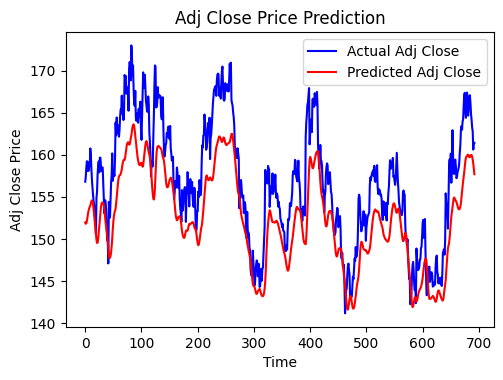

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_jnj_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_jnj_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


**Arima**

<Axes: xlabel='Date'>

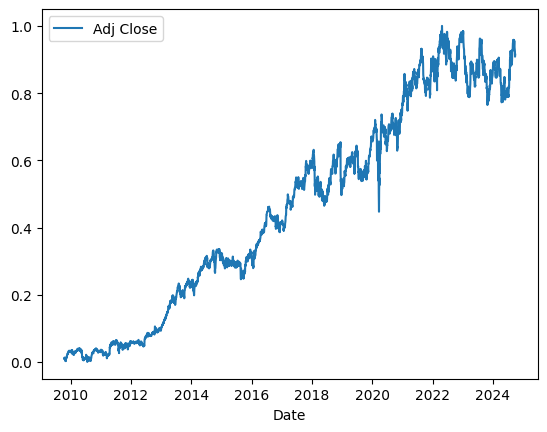

In [ ]:
df_jnj_scaled.plot() # label and date col are in thi dataset

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_jnj_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -0.7616846627210521
p-value 0.8301187067973762
critical values -24735.307139128716
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_jnj_scaled['first difference']=df_jnj_scaled['Adj Close']-df_jnj_scaled['Adj Close'].shift(1)


In the first-order differencing method, we subtract each data point from the previous one to remove trends and stabilize the series. This transformation is often enough to make the data stationary.

If the series does not become stationary after the first differencing, we apply second-order differencing, where the differencing process is repeated on the first-differenced data. This process can be continued (e.g., third-order differencing) until the data becomes stationary. However, it is important to stop once stationarity is achieved to avoid over-differencing, which can introduce unnecessary complexity.

<Axes: xlabel='Date'>

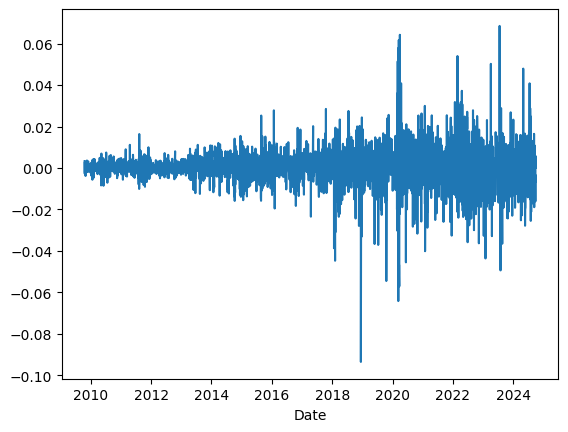

In [ ]:
# Now checking data is stationary or not using graphs.
df_jnj_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_jnj_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -15.788084813199099
p-value 1.1105969398873684e-28
critical values -24729.261508088704
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required.

### Lets implement ARIMA


Making Predictions for future values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error (MSE): 12.962613644224595
Mean Absolute Error (MAE): 2.897141789547337
Root Mean Squared Error (RMSE): 3.600362987842281


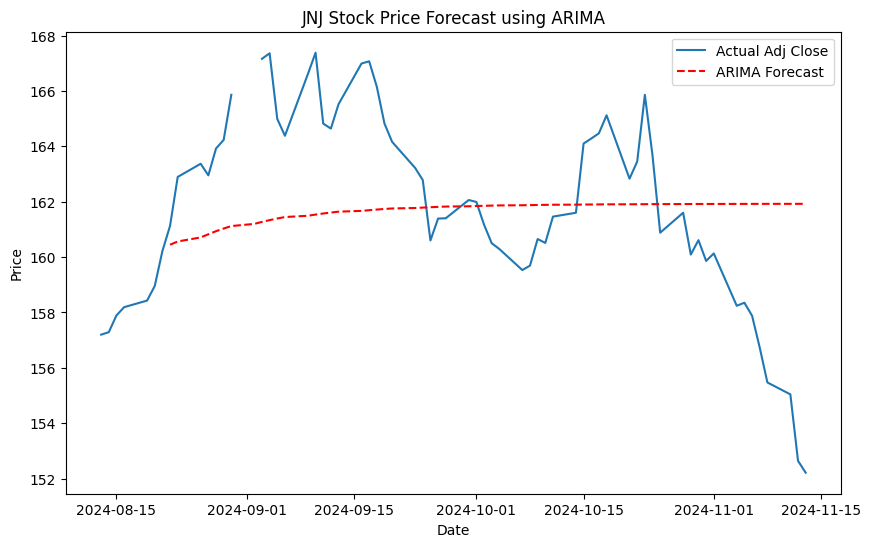

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_jnj_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_jnj_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_jnj_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_jnj_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_jnj_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_jnj_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("JNJ Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


The ARIMA model performs poorly because our dataset exhibits seasonality, and ARIMA is not well-suited for handling seasonal patterns effectively.

XGboost

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/JNJ.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          32.340625        0.124593       32.353925       0.507144
1          30.744099        0.118382       30.758555       0.484913
2          29.225788        0.112566       29.238180       0.462877
3          27.782474        0.107014       27.794573       0.445316
4          26.410910        0.101494       26.421934       0.428925
..               ...             ...             ...            ...
995         0.032368        0.000663        0.375440       0.042403
996         0.032319        0.000644        0.375432       0.042408
997         0.032263        0.000644        0.375428       0.042421
998         0.032214        0.000651        0.375431       0.042418
999         0.032153        0.000645        0.375417       0.042421

[1000 rows x 4 columns]
Best number of boosting rounds: 999


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=999, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error (MSE): 64.15315917818845
Root Mean Squared Error (RMSE): 8.009566728493398
Mean Absolute Error (MAE): 7.3314933371036615


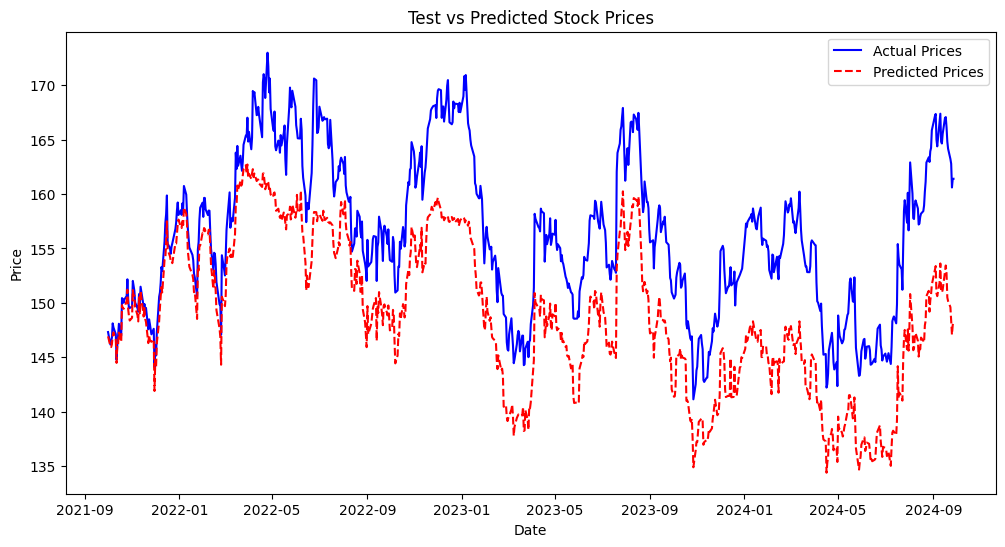

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  147.315109  146.922302
2021-10-04 00:00:00+00:00  146.167542  146.021194
2021-10-05 00:00:00+00:00  146.498016  145.935669
2021-10-06 00:00:00+00:00  146.800995  146.204422
2021-10-07 00:00:00+00:00  148.113754  146.971985


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_jnj.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


ARIMA struggles with seasonal data because it does not inherently account for recurring patterns, leading to inaccurate predictions even if error metrics appear similar. In contrast, LSTM excels at capturing both trends and seasonality by learning patterns over time.

While XGBoost outperforms ARIMA in terms of prediction accuracy, it is less effective than LSTM at capturing long-term trends and complex temporal dependencies. LSTM remains the best option for learning intricate patterns in time series data.

**KO dataset**

LSTM

In [ ]:
df_ko=pd.read_csv('/content/drive/MyDrive/ds/KO.csv')

In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_ko['Date'] = pd.to_datetime(df_ko['Date']).dt.date

In [ ]:
df_ko.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
ko_scaled = scaler.fit_transform(df_ko[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_ko_scaled = pd.DataFrame(ko_scaled, columns=['Adj Close'], index=df_ko.index)

In [ ]:
df_ko_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.023187
2009-10-19,0.021961
2009-10-20,0.017949
2009-10-21,0.017949
2009-10-22,0.018395


In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_ko_scaled['Adj Close'], window_size)


In [ ]:
split_index=3000 #80% for training
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 60, 1), (3000,), (702, 60, 1), (702,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 114s 129ms/step - RootMeanSquaredError: 0.0588 - loss: 0.0040 - val_RootMeanSquaredError: 0.0352 - val_loss: 0.0012
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 143s 130ms/step - RootMeanSquaredError: 0.0297 - loss: 8.8218e-04 - val_RootMeanSquaredError: 0.0488 - val_loss: 0.0024
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - RootMeanSquaredError: 0.0242 - loss: 5.8922e-04 - val_RootMeanSquaredError: 0.0262 - val_loss: 6.8775e-04
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 70ms/step - RootMeanSquaredError: 0.0236 - loss: 5.5871e-04 - val_RootMeanSquaredError: 0.0338 - val_loss: 0.0011
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 140s 143ms/step - RootMeanSquaredError: 0.0219 - loss: 4.8047e-04 - val_RootMeanSquaredError: 0.0321 - val_loss: 0.0010
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 122s 117ms/step - RootMeanSquaredError: 0.0212 - loss: 4.5266e-04 - val_RootMeanSquaredError: 0.0217 - val_loss: 4.6997e-04
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_ko.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 0.9690, RMSE: 1.2052, MSE: 1.4524


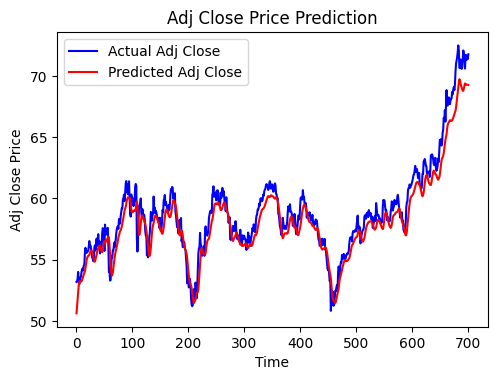

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_ko_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_ko_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


# Arima

<Axes: xlabel='Date'>

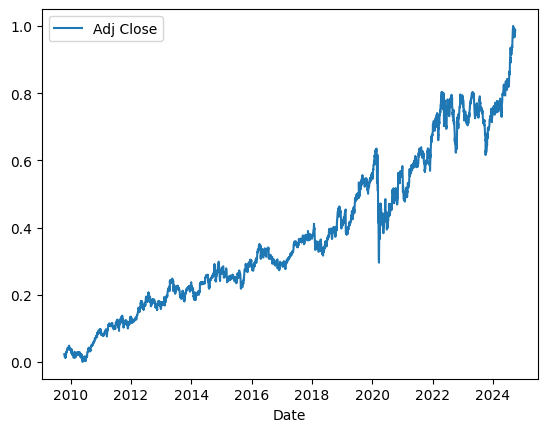

In [ ]:
df_ko_scaled.plot()

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_ko_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  0.24698049270788375
p-value 0.9747768566867208
critical values -25790.394914194796
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_ko_scaled['first difference']=df_ko_scaled['Adj Close']-df_ko_scaled['Adj Close'].shift(1)

<Axes: xlabel='Date'>

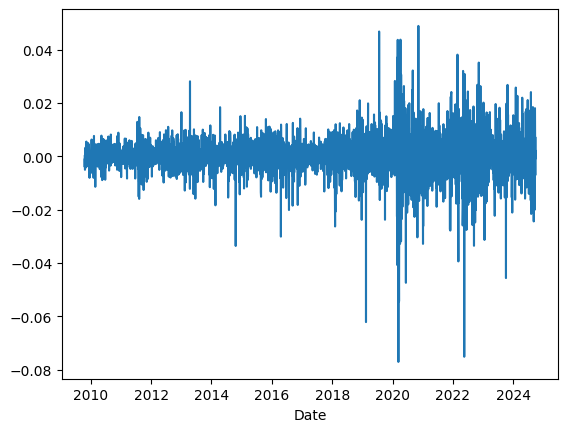

In [ ]:
# Now checking data is stationary or not using graphs.
df_ko_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_ko_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -18.73336778628322
p-value 2.0304190812652588e-30
critical values -25784.715254173367
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required.

### ARIMA Implementation

Mean Squared Error (MSE): 10.359854377492555
Mean Absolute Error (MAE): 2.331594970993585
Root Mean Squared Error (RMSE): 3.218672766450879


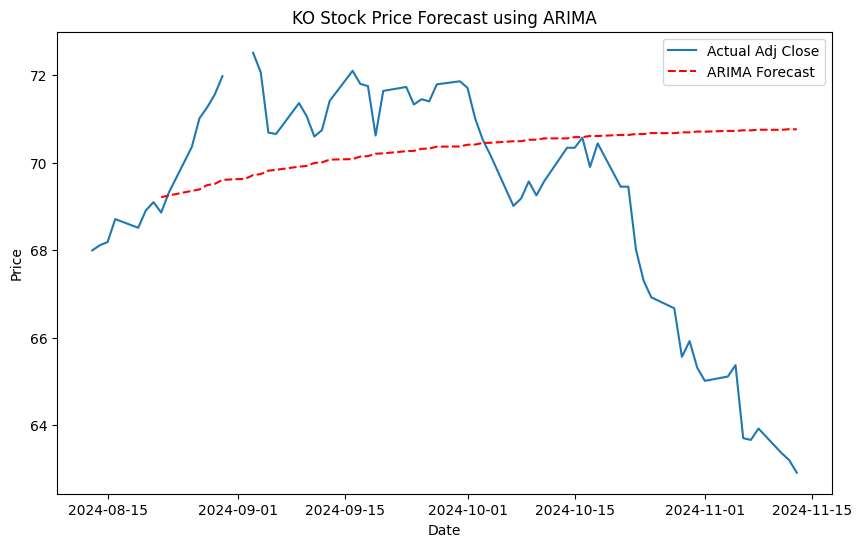

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_ko_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_ko_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_ko_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_ko_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_ko_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_ko_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("KO Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


XGboost

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/KO.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           8.463460        0.037154        8.469050       0.149918
1           8.046734        0.035082        8.052449       0.141877
2           7.650511        0.033474        7.655756       0.134014
3           7.274013        0.031664        7.279027       0.126247
4           6.916051        0.030205        6.920462       0.118439
..               ...             ...             ...            ...
995         0.011880        0.000616        0.159571       0.023672
996         0.011863        0.000615        0.159569       0.023675
997         0.011844        0.000622        0.159568       0.023674
998         0.011822        0.000619        0.159564       0.023682
999         0.011794        0.000616        0.159563       0.023682

[1000 rows x 4 columns]
Best number of boosting rounds: 999


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=999, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error (MSE): 65.60714221059537
Root Mean Squared Error (RMSE): 8.099823591325638
Mean Absolute Error (MAE): 7.035455196461779


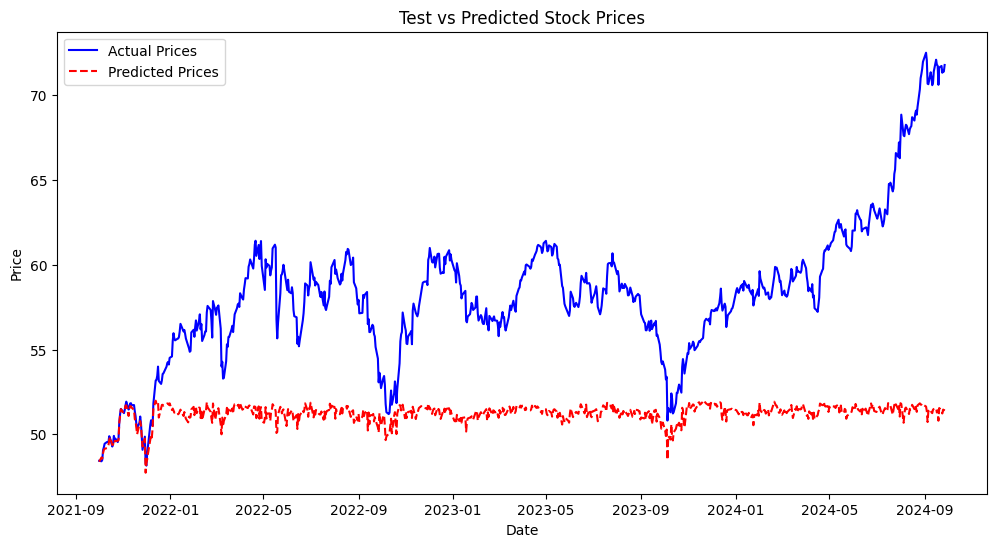

                              Actual  Predicted
Date                                           
2021-10-01 00:00:00+00:00  48.433788  48.381828
2021-10-04 00:00:00+00:00  48.406399  48.634037
2021-10-05 00:00:00+00:00  48.488609  48.567028
2021-10-06 00:00:00+00:00  49.064106  48.884796
2021-10-07 00:00:00+00:00  49.219402  49.077263


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_ko.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


MSFT dataset

In [ ]:
df_mfst=pd.read_csv('/content/drive/MyDrive/ds/MSFT-1.csv')

In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_mfst['Date'] = pd.to_datetime(df_mfst['Date']).dt.date

In [ ]:
df_mfst.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
mfst_scaled = scaler.fit_transform(df_mfst[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_mfst_scaled = pd.DataFrame(mfst_scaled, columns=['Adj Close'], index=df_mfst.index)

In [ ]:
df_mfst_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.005309
2009-10-19,0.005075
2009-10-20,0.005092
2009-10-21,0.005443
2009-10-22,0.005460


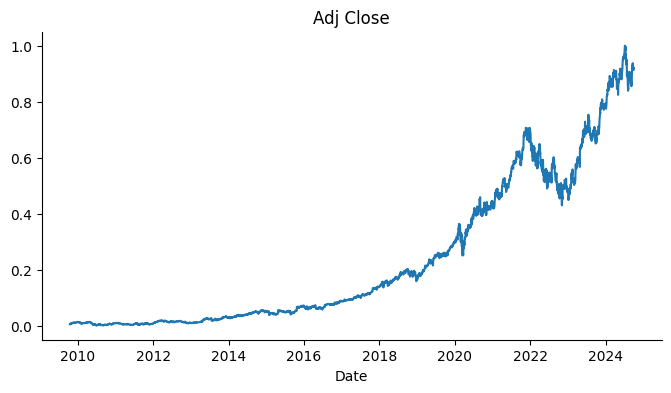

In [ ]:
# @title Adj Close

from matplotlib import pyplot as plt
df_mfst_scaled['Adj Close'].plot(kind='line', figsize=(8, 4), title='Adj Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_mfst_scaled['Adj Close'], window_size)


In [ ]:
split_index=3000 #80% for training and rest for test
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 60, 1), (3000,), (702, 60, 1), (702,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 125s 135ms/step - RootMeanSquaredError: 0.0219 - loss: 5.3004e-04 - val_RootMeanSquaredError: 0.0418 - val_loss: 0.0017
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 140s 134ms/step - RootMeanSquaredError: 0.0144 - loss: 2.0923e-04 - val_RootMeanSquaredError: 0.0481 - val_loss: 0.0023
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 107s 134ms/step - RootMeanSquaredError: 0.0136 - loss: 1.8564e-04 - val_RootMeanSquaredError: 0.0334 - val_loss: 0.0011
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 107s 91ms/step - RootMeanSquaredError: 0.0114 - loss: 1.3102e-04 - val_RootMeanSquaredError: 0.0195 - val_loss: 3.8097e-04
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - RootMeanSquaredError: 0.0113 - loss: 1.2845e-04 - val_RootMeanSquaredError: 0.0663 - val_loss: 0.0044
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 83s 69ms/step - RootMeanSquaredError: 0.0125 - loss: 1.5572e-04 - val_RootMeanSquaredError: 0.0184 - val_loss: 3.3732e-04
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_mfst.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

Adj Close - MAE: 22.1629, RMSE: 28.8909, MSE: 834.6851


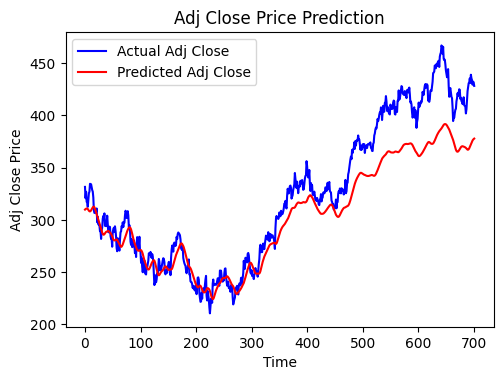

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_mfst_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_mfst_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


**ARIMA**

<Axes: xlabel='Date'>

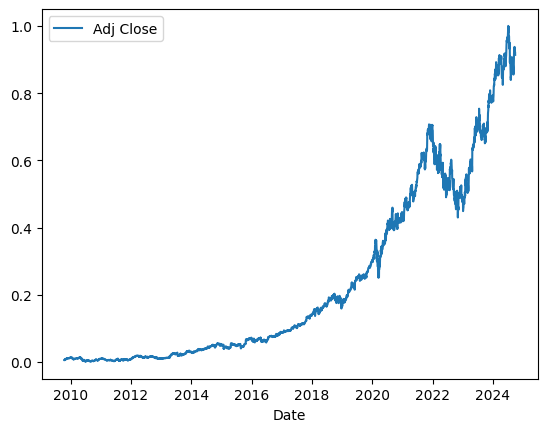

In [ ]:
df_mfst_scaled.plot()

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_mfst_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  2.170775909511177
p-value 0.9988575856942729
critical values -27395.005909946216
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_mfst_scaled['first difference']=df_mfst_scaled['Adj Close']-df_mfst_scaled['Adj Close'].shift(1)

<Axes: xlabel='Date'>

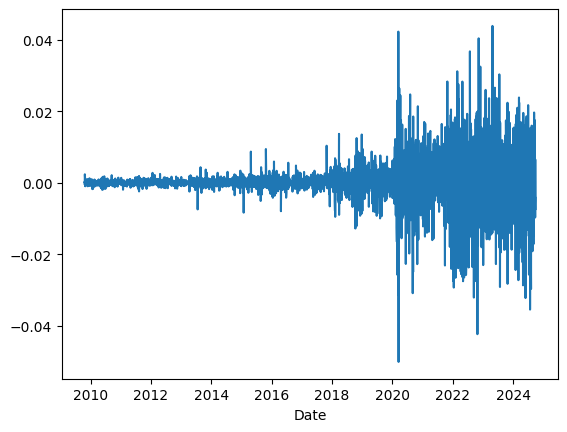

In [ ]:
# Now checking data is stationary or not using graphs.
df_mfst_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_mfst_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -13.587270426152434
p-value 2.068867726039771e-25
critical values -27383.941265448433
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error (MSE): 90.47839147742067
Mean Absolute Error (MAE): 8.163346550027697
Root Mean Squared Error (RMSE): 9.512013008686472


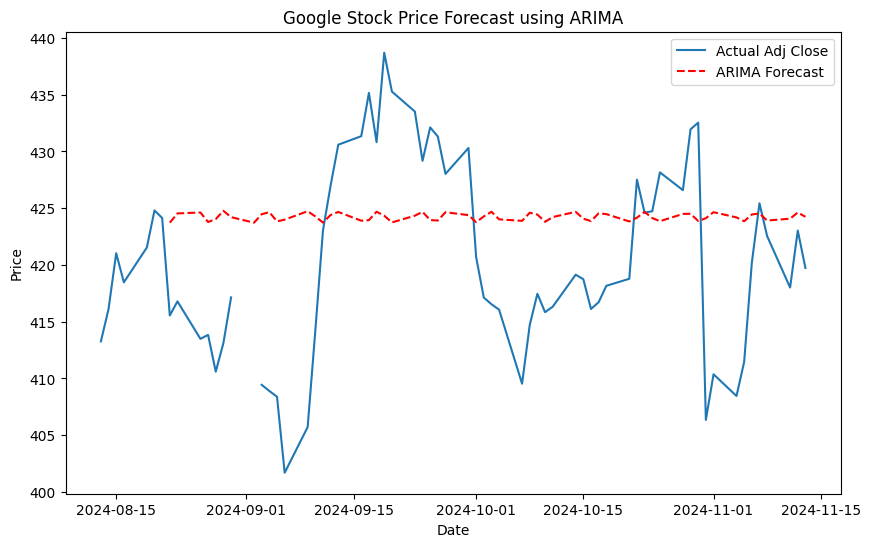

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_mfst_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_mfst_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_mfst_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_mfst_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_mfst_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_mfst_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("Google Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


XGBoost

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/MSFT-1.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          64.427464        0.786700       64.396499       3.187235
1          61.264635        0.748864       61.229786       3.032479
2          58.252936        0.710910       58.219210       2.888485
3          55.388467        0.674938       55.364272       2.757584
4          52.663613        0.640338       52.639490       2.629197
..               ...             ...             ...            ...
505         0.094155        0.003169        0.520237       0.048079
506         0.093983        0.003155        0.520262       0.048085
507         0.093784        0.003149        0.520256       0.048139
508         0.093601        0.003153        0.520231       0.048134
509         0.093391        0.003127        0.520207       0.048139

[510 rows x 4 columns]
Best number of boosting rounds: 509


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=509, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error (MSE): 4829.390285606165
Root Mean Squared Error (RMSE): 69.49381472912654
Mean Absolute Error (MAE): 47.580836154044945


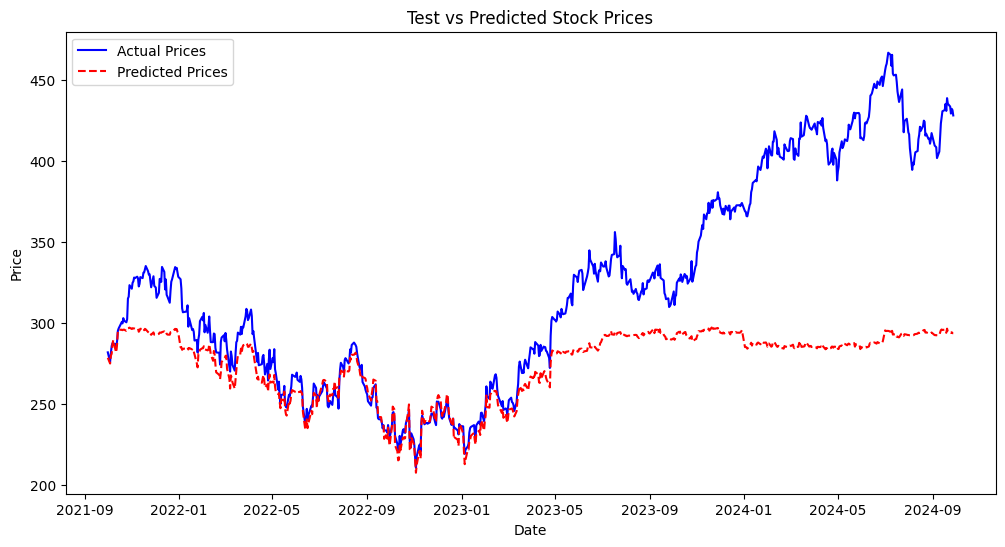

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  281.840149  278.497620
2021-10-04 00:00:00+00:00  276.000519  274.934601
2021-10-05 00:00:00+00:00  281.508698  279.795135
2021-10-06 00:00:00+00:00  285.749420  280.999481
2021-10-07 00:00:00+00:00  287.445679  286.809814


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_msft.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


**Netflix**

LSTM

In [ ]:
df_net=pd.read_csv('/content/drive/MyDrive/ds/NETFLIX.csv')

In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_net['Date'] = pd.to_datetime(df_net['Date']).dt.date

In [ ]:
df_net.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
net_scaled = scaler.fit_transform(df_net[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_net_scaled = pd.DataFrame(net_scaled, columns=['Adj Close'], index=df_net.index)

In [ ]:
df_net_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.000228
2009-10-19,0.000389
2009-10-20,0.000222
2009-10-21,0.000000
2009-10-22,0.000355


In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_net_scaled['Adj Close'], window_size)


In [ ]:
split_index=3000
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 60, 1), (3000,), (702, 60, 1), (702,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 122s 139ms/step - RootMeanSquaredError: 0.0495 - loss: 0.0025 - val_RootMeanSquaredError: 0.0664 - val_loss: 0.0044
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 140s 136ms/step - RootMeanSquaredError: 0.0303 - loss: 9.3344e-04 - val_RootMeanSquaredError: 0.0385 - val_loss: 0.0015
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - RootMeanSquaredError: 0.0315 - loss: 9.9929e-04 - val_RootMeanSquaredError: 0.0585 - val_loss: 0.0034
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 95s 78ms/step - RootMeanSquaredError: 0.0277 - loss: 7.6998e-04 - val_RootMeanSquaredError: 0.0302 - val_loss: 9.1459e-04
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 69ms/step - RootMeanSquaredError: 0.0272 - loss: 7.4089e-04 - val_RootMeanSquaredError: 0.0368 - val_loss: 0.0014
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - RootMeanSquaredError: 0.0275 - loss: 7.5596e-04 - val_RootMeanSquaredError: 0.0290 - val_loss: 8.4038e-04
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 81

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_netflix.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 21.2654, RMSE: 28.7055, MSE: 824.0082


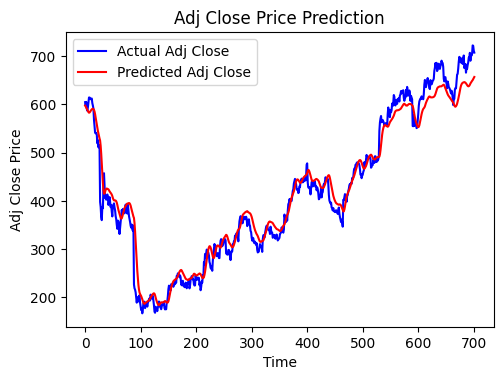

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_net_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_net_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


ARIMA

<Axes: xlabel='Date'>

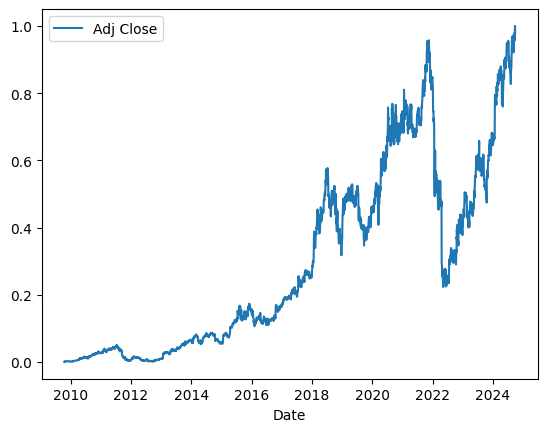

In [ ]:
df_net_scaled.plot()

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_net_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  0.0067063456630643056
p-value 0.9590831946618962
critical values -23508.546540422853
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_net_scaled['first difference']=df_net_scaled['Adj Close']-df_net_scaled['Adj Close'].shift(1)

<Axes: xlabel='Date'>

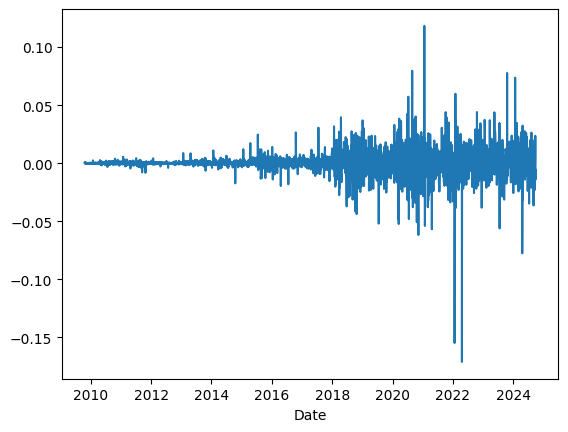

In [ ]:
# Now checking data is stationary or not using graphs.
df_net_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_net_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -10.920505590821122
p-value 1.0409563444879327e-19
critical values -23503.9897052116
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required.

### ARIMA Implementation

Mean Squared Error (MSE): 2328.190292014053
Mean Absolute Error (MAE): 34.62886922707255
Root Mean Squared Error (RMSE): 48.251324251403226


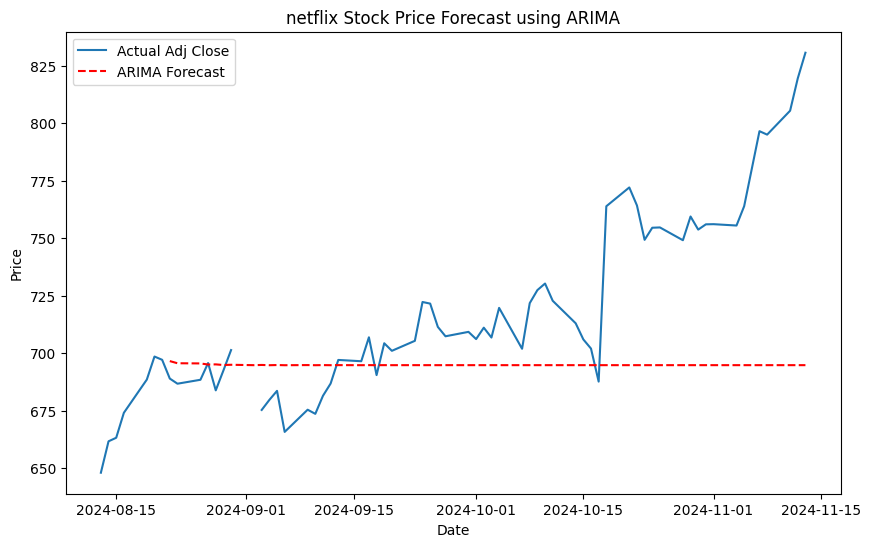

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_net_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_net_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_net_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_net_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_net_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_net_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("netflix Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


XGboost

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/NETFLIX.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         162.017587        0.926883      162.027593       3.713543
1         154.016749        0.883669      154.052490       3.539819
2         146.407440        0.841111      146.441004       3.365452
3         139.173321        0.794775      139.197879       3.192815
4         132.292404        0.757332      132.315078       3.026752
..               ...             ...             ...            ...
367         0.293884        0.007625        1.273778       0.091913
368         0.293063        0.007531        1.273866       0.092041
369         0.292286        0.007332        1.273850       0.091873
370         0.291715        0.007497        1.273699       0.091803
371         0.290987        0.007393        1.273666       0.091775

[372 rows x 4 columns]
Best number of boosting rounds: 371


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=371, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error (MSE): 904.3928950829081
Root Mean Squared Error (RMSE): 30.073125795016853
Mean Absolute Error (MAE): 15.582005054392713


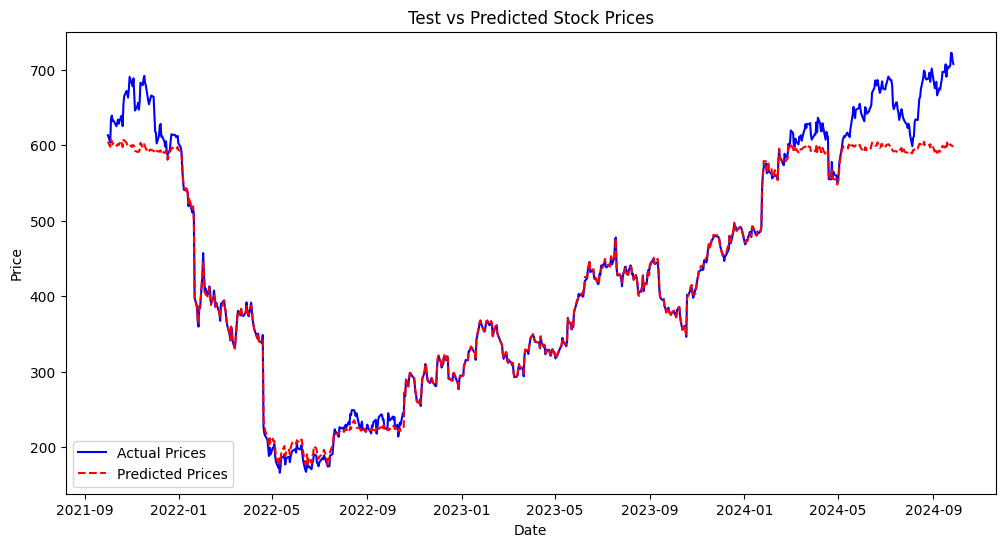

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  613.150024  604.335022
2021-10-04 00:00:00+00:00  603.349976  597.870972
2021-10-05 00:00:00+00:00  634.809998  606.927429
2021-10-06 00:00:00+00:00  639.099976  605.392273
2021-10-07 00:00:00+00:00  631.849976  600.991821


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_netflix.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


**NIKE dataste**

LSTM

In [ ]:
df_nike=pd.read_csv('/content/drive/MyDrive/ds/NIKE.csv')

In [ ]:
#converting the dataype of 'Date' col to 'datetime'
df_nike['Date'] = pd.to_datetime(df_nike['Date']).dt.date

In [ ]:
df_nike.set_index('Date', inplace = True)

In [ ]:
scaler = MinMaxScaler()
nike_scaled = scaler.fit_transform(df_nike[['Adj Close']])  # Double brackets to pass it as a DataFrame
df_nike_scaled = pd.DataFrame(nike_scaled, columns=['Adj Close'], index=df_nike.index)

In [ ]:
df_nike_scaled.head() #to observe first 5 rows

,Adj Close
Date,
2009-10-16,0.004661
2009-10-19,0.005962
2009-10-20,0.004647
2009-10-21,0.004201
2009-10-22,0.004779


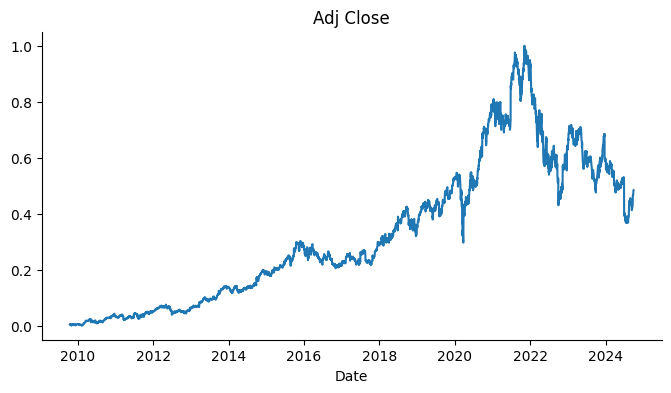

In [ ]:
from matplotlib import pyplot as plt
df_nike_scaled['Adj Close'].plot(kind='line', figsize=(8, 4), title='Adj Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import numpy as np

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)  # 60 time steps for each sample
        y.append(data.iloc[i])  # The target value
    X = np.array(X)
    y = np.array(y)
    # Reshape X to 3D (samples, time steps, features) for LSTM input
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequence(df_nike_scaled['Adj Close'], window_size)


In [ ]:
split_index=3000
# Split the data based on the split index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the splits
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 60, 1), (3000,), (702, 60, 1), (702,))

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer with 1 unit
    keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 115s 135ms/step - RootMeanSquaredError: 0.0474 - loss: 0.0026 - val_RootMeanSquaredError: 0.0500 - val_loss: 0.0025
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 100s 82ms/step - RootMeanSquaredError: 0.0273 - loss: 7.4644e-04 - val_RootMeanSquaredError: 0.0621 - val_loss: 0.0039
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 129s 141ms/step - RootMeanSquaredError: 0.0238 - loss: 5.7398e-04 - val_RootMeanSquaredError: 0.1134 - val_loss: 0.0129
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 133s 130ms/step - RootMeanSquaredError: 0.0236 - loss: 5.5790e-04 - val_RootMeanSquaredError: 0.0556 - val_loss: 0.0031
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 105s 131ms/step - RootMeanSquaredError: 0.0209 - loss: 4.3741e-04 - val_RootMeanSquaredError: 0.0387 - val_loss: 0.0015
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 97s 75ms/step - RootMeanSquaredError: 0.0214 - loss: 4.5941e-04 - val_RootMeanSquaredError: 0.1001 - val_loss: 0.0100
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 77s 70m

In [ ]:
model.save('/content/drive/MyDrive/ds/lstm_nike.keras')

In [ ]:
predictions=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


In [ ]:
predictions=scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Adj Close - MAE: 3.1405, RMSE: 4.1584, MSE: 17.2924


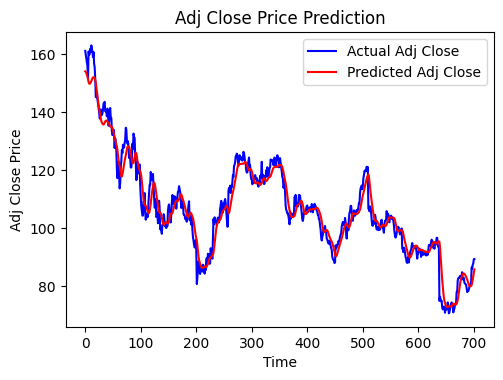

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and predictions are inverse transformed and have the same shape

# Initialize lists to store error metrics for each column
mae_scores = []
rmse_scores = []
mse_scores = []

# Calculate error metrics for each column and plot
plt.figure(figsize=(14, 7))

for i, col in enumerate(df_nike_scaled.columns):
    # Calculate MAE, RMSE, and MSE for the current column
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mse = mean_squared_error(y_test[:, i], predictions[:, i])

    # Append scores for each metric
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mse_scores.append(mse)

    # Plotting actual vs. predicted prices for the current column
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()
    plt.tight_layout()

# Displaying the error metrics for each column
for i, col in enumerate(df_nike_scaled.columns):
    print(f"{col} - MAE: {mae_scores[i]:.4f}, RMSE: {rmse_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}")


ARIMA

<Axes: xlabel='Date'>

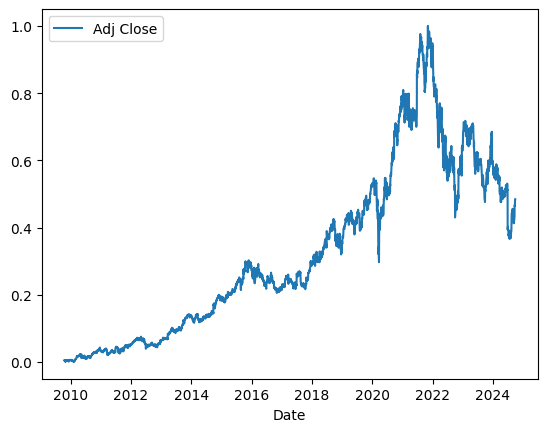

In [ ]:
df_nike_scaled.plot()

The data clearly demonstrates an upward trend with seasonality. It's important to note that ARIMA models assume the data is stationary, meaning the statistical properties such as mean and variance do not change over time. Stationary data is easier to forecast, and the resulting predictions are more reliable. In contrast, non-stationary data often exhibits trends and seasonality, as seen in this dataset, where the mean and variance change over time.

To determine if data is stationary, we can use two approaches: graphical analysis and statistical testing. Visual inspection of graphs can provide insights into the presence of trends or seasonality, but it is subjective and less reliable. On the other hand, statistical tests, like the Dickey-Fuller test, offer a quantitative and evidence-based method to assess stationarity.

The Dickey-Fuller test examines whether a time series is stationary by testing the null hypothesis that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis and conclude that the data is stationary. Conversely, if the p-value is 0.05 or higher, we fail to reject the null hypothesis, indicating that the data is non-stationary.

If the data is non-stationary, transformations such as differencing or detrending are typically applied to make it stationary. This step is essential for using models like ARIMA effectively, as they perform best when the input data does not exhibit trends or seasonality. Statistical tests, particularly the Dickey-Fuller test, provide a robust way to validate the stationarity of data and guide the preprocessing needed for reliable forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=df_nike_scaled['Adj Close']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -1.3429403897345504
p-value 0.6093053932337146
critical values -24489.02222409258
Reject the null hypotheise , it means data is not stationary


Based on these results, we fail to reject the null hypothesis because the p-value is significantly greater than 0.05. This indicates that the data is not stationary.

Non-stationary data can be transformed into stationary data using various methods, such as:

Differencing: Applying the first, second, or third order of differencing is the most commonly used method.

Logarithmic Transformation: Taking the logarithm of the data can stabilize variance and reduce trends.

Moving Averages: Smoothing the series by applying a moving average with a window length equal to the seasonality period.

In this case, we will convert the non-stationary data into stationary data using the first-order differencing method. This will help eliminate the trend and make the data suitable for forecasting models like ARIMA.

In [ ]:
df_nike_scaled['first difference']=df_nike_scaled['Adj Close']-df_nike_scaled['Adj Close'].shift(1)

<Axes: xlabel='Date'>

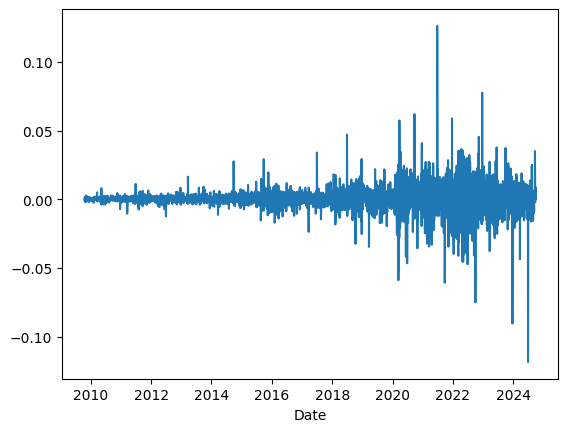

In [ ]:
# Now checking data is stationary or not using graphs.
df_nike_scaled['first difference'].plot()

The data appears to be stationary, as the mean and standard deviation do not seem to change over time.

To confirm this with stronger evidence, we will perform the Dickey-Fuller statistical test to validate the stationarity of the data.

In [ ]:
x=df_nike_scaled['first difference'].dropna()
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it means data is stationary")
else:
    print("Reject the null hypotheise , it means data is not stationary")

ADF Stataics  -11.518720640740645
p-value 4.0894768502409225e-21
critical values -24481.63121576675
fail to reject null hypothese h1 , it means data is stationary


After performing the first-order differencing, the p-value is less than 0.05. This means we reject the null hypothesis and accept the alternative hypothesis, indicating that the data is now stationary.

Since the data has become stationary, no further differencing is required.

### ARIMA Implementation

Mean Squared Error (MSE): 15.771924782929156
Mean Absolute Error (MAE): 3.254435556403699
Root Mean Squared Error (RMSE): 3.9713882689720927


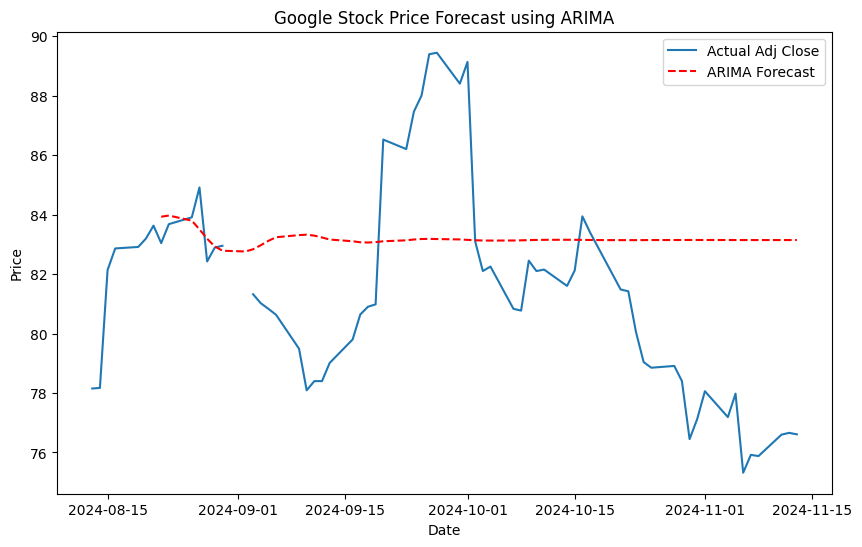

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `data` is already loaded with 'Adj Close' and indexed by date
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # Set to business day frequency

# Define and fit the ARIMA model
model1 = ARIMA(data['Adj Close'], order=(2, 1, 2))
model_fit1 = model1.fit()

# Forecast and extend into the future by 10 days
forecast_steps = 10
df_nike_scaled = data.copy()

# Generate the forecast (use `len(data) - 1` to avoid gaps)
df_nike_scaled['forecast_ARIMA'] = model_fit1.predict(
    start=len(data) - 60,
    end=len(data) + forecast_steps - 1,
    dynamic=True
)

# Calculate metrics if forecast column exists
if 'forecast_ARIMA' in df_nike_scaled.columns:
    # Get overlapping period for actual and forecasted values
    forecast_period = df_nike_scaled[['Adj Close', 'forecast_ARIMA']].dropna()

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    mae = mean_absolute_error(forecast_period['Adj Close'], forecast_period['forecast_ARIMA'])
    rmse = np.sqrt(mse)

    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: 'forecast_ARIMA' column was not created successfully.")

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_nike_scaled['Adj Close'], label='Actual Adj Close')
plt.plot(df_nike_scaled['forecast_ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.title("Google Stock Price Forecast using ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


XGBoost

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the Apple stock dataset (make sure your 'Date' column is in datetime format)
df = pd.read_csv('/content/drive/MyDrive/ds/NIKE.csv', parse_dates=['Date'], index_col='Date', encoding='ISO-8859-1')

# Feature engineering: Create lag features (shifted columns of 'Adj Close')
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Adj Close'].shift(i)
    return df

# Create lag features (for example, lag of 5 days)
df = create_lag_features(df, lag=5)

# Drop rows with NaN values (generated by shifting)
df.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df.drop(['Adj Close'], axis=1)  # All columns except 'Adj Close'
y = df['Adj Close']  # Target is 'Adj Close'

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
#  DMatrix is the internal data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression problems
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Cross-validation with XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    early_stopping_rounds=50,  # Stop if the performance doesn't improve after 50 rounds
    metrics="rmse",  # Metric to monitor (RMSE in this case)
    as_pandas=True,  # Return results as a Pandas DataFrame
    seed=42  # Set random seed for reproducibility
)

# Display the cross-validation results
print(cv_results)

# Get the best number of boosting rounds from cross-validation
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Best number of boosting rounds: {best_num_rounds}')

# Train the model using the best number of rounds from cross-validation
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=best_num_rounds,
    subsample=0.8,
    colsample_bytree=0.8
)



     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          33.064992        0.349423       33.063268       1.417375
1          31.437272        0.330350       31.436867       1.358865
2          29.891801        0.313082       29.893886       1.302464
3          28.423326        0.298385       28.430992       1.245440
4          27.026266        0.282193       27.037025       1.196471
..               ...             ...             ...            ...
582         0.050853        0.001046        0.340091       0.045265
583         0.050747        0.001058        0.340063       0.045267
584         0.050639        0.001059        0.340051       0.045253
585         0.050541        0.001042        0.340033       0.045260
586         0.050449        0.001033        0.340028       0.045252

[587 rows x 4 columns]
Best number of boosting rounds: 586


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=586, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error (MSE): 3.1447429140112333
Root Mean Squared Error (RMSE): 1.7733423002937796
Mean Absolute Error (MAE): 1.3589177638926404


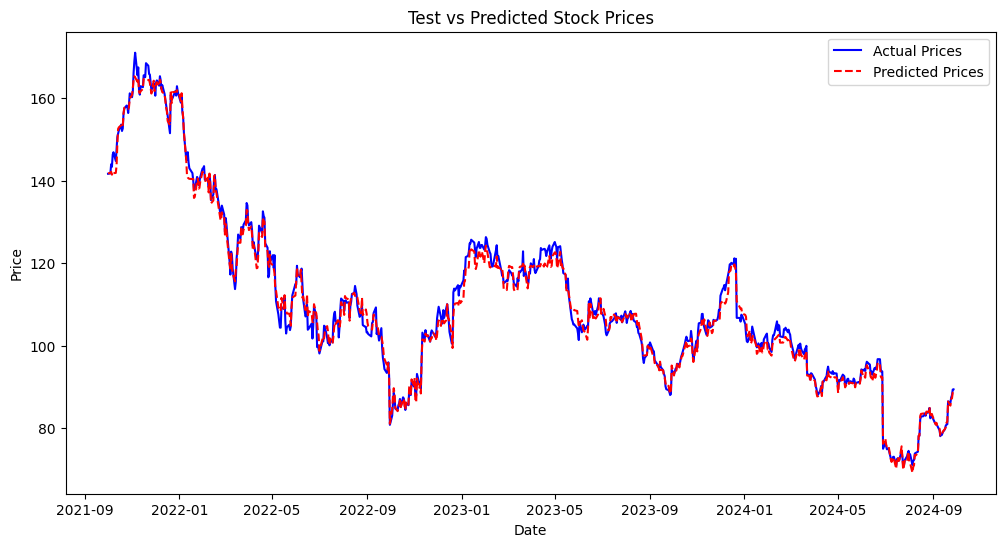

                               Actual   Predicted
Date                                             
2021-10-01 00:00:00+00:00  141.683807  141.761642
2021-10-04 00:00:00+00:00  141.760880  141.903137
2021-10-05 00:00:00+00:00  143.996063  142.162720
2021-10-06 00:00:00+00:00  143.360184  141.460266
2021-10-07 00:00:00+00:00  146.298706  142.125839


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test, y_pred)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual test values
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')

# Plot predicted values
plt.plot(y_test.index, y_pred, label='Predicted Prices', linestyle='--', color='red')

# Chart details
plt.title('Test vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few predicted vs actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


In [ ]:
import pickle

# Save the trained model to a file
with open('/content/drive/MyDrive/ds/xgboost_model_nike.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved successfully!")


Model saved successfully!


### Key Methods and Techniques applied in the analysis:

1. Early Stopping:

Early stopping is a technique used to prevent overfitting during model training. It monitors a validation metric, and if performance does not improve after a predefined number of epochs, training is stopped. This prevents unnecessary training epochs that could harm the model's generalization on unseen data.

2. MinMax Scaling:

MinMax scaling normalizes data to a specific range, typically 0 to 1. This ensures that all features are on a comparable scale, which is crucial for neural networks like LSTM to avoid dominance by features with larger values. MinMax scaling also accelerates convergence during training, leading to faster and more stable optimization.

3. Setting Date as the Index:

Setting the date as the index in each dataset is essential for time series analysis. It preserves the chronological order of data, allowing accurate splitting into training and testing sets. This step is critical for models to learn temporal patterns effectively.

### Final Conclusion

LSTM outperformed both XGBoost and ARIMA across all datasets, except for the Nike dataset, where XGBoost demonstrated a slightly better performance than LSTM. ARIMA consistently underperformed on all datasets due to its inability to effectively handle the seasonal nature of the data.

We will use LSTM for our web based app.